### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Download data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

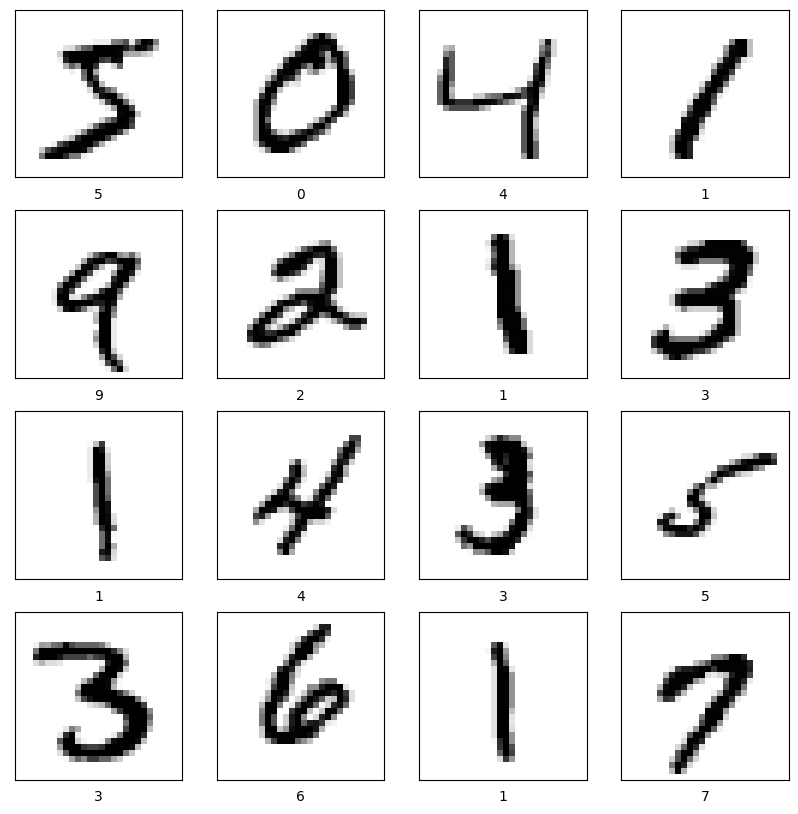

In [3]:
plt.figure(figsize=(10,10))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Normalize Data

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
x_train = np.reshape(x_train, (60000, 28*28))
x_test = np.reshape(x_test, (10000, 28*28))

x_train = x_train / 255.
x_test = x_test / 255.

In [7]:
x_train[0].shape

(784,)

### CNN Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [9]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=1024,
    verbose=2
)

Epoch 1/20
59/59 - 3s - loss: 2.2271 - accuracy: 0.3017 - val_loss: 2.0303 - val_accuracy: 0.5510 - 3s/epoch - 44ms/step
Epoch 2/20
59/59 - 1s - loss: 1.8577 - accuracy: 0.6435 - val_loss: 1.6572 - val_accuracy: 0.7158 - 633ms/epoch - 11ms/step
Epoch 3/20
59/59 - 1s - loss: 1.4878 - accuracy: 0.7467 - val_loss: 1.3016 - val_accuracy: 0.7906 - 626ms/epoch - 11ms/step
Epoch 4/20
59/59 - 1s - loss: 1.1660 - accuracy: 0.8105 - val_loss: 1.0170 - val_accuracy: 0.8400 - 626ms/epoch - 11ms/step
Epoch 5/20
59/59 - 1s - loss: 0.9143 - accuracy: 0.8512 - val_loss: 0.8007 - val_accuracy: 0.8706 - 614ms/epoch - 10ms/step
Epoch 6/20
59/59 - 1s - loss: 0.7292 - accuracy: 0.8740 - val_loss: 0.6474 - val_accuracy: 0.8868 - 596ms/epoch - 10ms/step
Epoch 7/20
59/59 - 1s - loss: 0.6002 - accuracy: 0.8871 - val_loss: 0.5424 - val_accuracy: 0.8968 - 591ms/epoch - 10ms/step
Epoch 8/20
59/59 - 1s - loss: 0.5111 - accuracy: 0.8961 - val_loss: 0.4700 - val_accuracy: 0.9025 - 607ms/epoch - 10ms/step
Epoch 9/20


### Saving the model

In [10]:
model.save('model.h5')

### Creating a model server

In [25]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]
)

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index, :, :]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({
            'prediction': final_preds,
            'image': image.tolist()
        })
    return 'Welcome to model server!'

if __name__ == '__main__':
    app.run()

Overwriting ml_server.py


In [8]:
%%writefile app.py

import streamlit as st
from collections.abc import Iterable
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))
    
    st.sidebar.image(image, width=150)
    
    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        fig = plt.figure(figsize=(32,4))
        
        if layer==2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16
        for i, number in enumerate(numbers):
            ax = plt.subplot(row, col, i+1)
            ax.imshow(number * np.ones((8, 8, 3)).astype('float32'))
            ax.set_xticks([])
            ax.set_yticks([])
            
            if layer==2:
                ax.set_xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot(fig)

Overwriting app.py
